# Visualiser for area28 metric data

In [24]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [110]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data as CSV / json file

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# df = pd.read_json("data.json")
df = pd.read_csv("dummy.csv")
df = df.set_index('id')
df.tail()

,type,userId,sceneId,timestamp,data
id,,,,,
177c317c-895d-42eb-9f1f-9952256196a3,CORE_SCENE_JOIN,4e9c72fb-0fbf-4f2f-82de-5e66d319ee72,a569e336-75dd-4a54-8e33-fa758d38bc86,2021-11-22 09:38:54,"{'ratingValue': None, 'ratingCategory': None}"
63ed44e0-94a8-4aa6-9541-5354168ea1ca,CORE_SCENE_LEAVE,4e9c72fb-0fbf-4f2f-82de-5e66d319ee72,a569e336-75dd-4a54-8e33-fa758d38bc86,2021-11-22 11:08:25,"{'ratingValue': None, 'ratingCategory': None}"
ab382320-10f7-44b8-8109-c597a9e8479d,CORE_SCENE_JOIN,66094da0-1b69-4181-9df7-765bfc52bab3,a569e336-75dd-4a54-8e33-fa758d38bc86,2021-11-22 11:33:24,"{'ratingValue': None, 'ratingCategory': None}"
34ef2a8b-7951-48d8-9a05-10c6b901ea16,CORE_SCENE_LEAVE,66094da0-1b69-4181-9df7-765bfc52bab3,a569e336-75dd-4a54-8e33-fa758d38bc86,2021-11-22 14:21:09,"{'ratingValue': None, 'ratingCategory': None}"
a27ab792-4b42-42cd-8764-0bf40d3e1706,CORE_SCENE_RATE,66094da0-1b69-4181-9df7-765bfc52bab3,a569e336-75dd-4a54-8e33-fa758d38bc86,2021-11-22 14:21:47,"{'ratingValue': 3, 'ratingCategory': 'Cat5'}"


## Pre-process data to be visualised

In [112]:
import calendar

df_no_rating = df.drop(df[df['type'] == "CORE_SCENE_RATE"].index)

df_no_rating['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_no_rating['timestamp']]
durations = df_no_rating.groupby(['userId'])['datetime'].diff()
df_no_rating['date'] = [dt.datetime.date(d) for d in df_no_rating['datetime']] 
df_no_rating['time'] = [dt.datetime.time(d) for d in df_no_rating['datetime']]
df_no_rating['weekday'] = [calendar.day_name[d.weekday()] for d in df_no_rating['datetime']]
df_no_rating['week_number'] = [d.isocalendar()[1] for d in df_no_rating['datetime']]

df_no_rating['duration'] = durations
df_processed = df_no_rating[['userId', 'date', 'duration', 'time', 'weekday', 'week_number', 'sceneId']].copy()
df_processed = df_processed.dropna()
df_processed.head()

,userId,date,duration,time,weekday,week_number,sceneId
id,,,,,,,
04583902-29aa-47a3-9abc-dd57209cf06b,015e623d-6aa6-4231-af17-85cc106995b6,2021-06-03,0 days 03:40:03,13:51:15,Thursday,22,7e9c0078-d7bc-4817-927b-134c3174183c
fa07ed13-9206-43a8-a43f-79e51c62e7d6,401ddbdb-b8d9-42e2-b2dd-279a37636402,2021-06-03,0 days 01:58:48,14:46:24,Thursday,22,7e9c0078-d7bc-4817-927b-134c3174183c
a8f7b817-85a6-4b6a-a632-21c421623327,b9eb5b7c-c01f-4583-a1f1-4f8fc825fa93,2021-06-03,0 days 04:17:48,15:22:34,Thursday,22,7e9c0078-d7bc-4817-927b-134c3174183c
d361c863-c3df-45e4-be4c-d5b06e1b69f1,f1f48f2a-de15-4924-b7f0-989e909c0183,2021-06-03,0 days 02:42:42,14:29:37,Thursday,22,7e9c0078-d7bc-4817-927b-134c3174183c
2b98955f-943f-4c3c-bf56-a3a40e9643da,3f7c57cf-537b-434a-84e5-e0cdd1a844fe,2021-06-03,0 days 00:41:52,12:46:44,Thursday,22,7e9c0078-d7bc-4817-927b-134c3174183c


In [113]:
total_hours = df_processed['duration'].sum().days * 24 + df_processed['duration'].sum().seconds//3600
total_hours

41307

In [114]:
len(df['sceneId'].unique())

123

In [115]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ipywidgets -q

import ipywidgets as widgets
from IPython.display import display

In [116]:
dropdown_timeframe = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler(change):
    common_filtering(change.new, dropdown_user.value)

def dropdown_user_eventhandler(change):
    common_filtering(dropdown_timeframe.value, change.new)
    
def common_filtering(timeframe, user):
    output_widget.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget:
        display(df_processed_user_timeframed)

dropdown_timeframe.observe(dropdown_timeframe_eventhandler, names='value')
dropdown_user.observe(dropdown_user_eventhandler, names='value')
display(dropdown_timeframe)
display(dropdown_user)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

In [117]:
display(output_widget)

Output()

## Activity heatmap

In [118]:
from pandas import DataFrame
import seaborn as sns
import time

In [119]:
dropdown_timeframe_hm = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_hm = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_heatmap_widget = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_hm(change):
    common_filtering_hm(change.new, dropdown_user_hm.value)

def dropdown_user_eventhandler_hm(change):
    common_filtering_hm(dropdown_timeframe_hm.value, change.new)
    
def common_filtering_hm(timeframe, user):
    output_heatmap_widget.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_heatmap_widget:
        df_processed_user_timeframed['seconds'] = [d.total_seconds() for d in df_processed_user_timeframed['duration']]
        df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed_user_timeframed.groupby(['week_number', 'weekday'])['seconds'].sum()}).reset_index()
        df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='week_number', values='seconds')
        df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
        df_heatmap.sort_index(level=0, inplace=True)

        mask = df_heatmap.isnull()
        sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest', mask=mask)
        plt.show()

dropdown_timeframe_hm.observe(dropdown_timeframe_eventhandler_hm, names='value')
dropdown_user_hm.observe(dropdown_user_eventhandler_hm, names='value')
display(dropdown_timeframe_hm)
display(dropdown_user_hm)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

In [120]:
display(output_heatmap_widget)

Output()

# Pie chart of time spent in different scenes

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

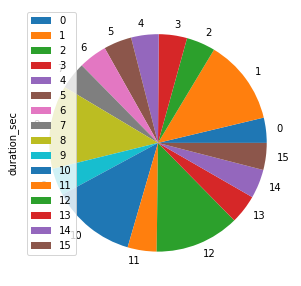

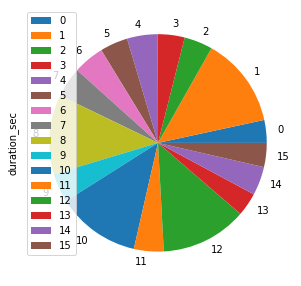

In [125]:
dropdown_timeframe_timespent = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_timespent = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_timespent = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_timespent(change):
    common_filtering_timespent(change.new, dropdown_user_timespent.value)

def dropdown_user_eventhandler_timespent(change):
    common_filtering_timespent(dropdown_timeframe_timespent.value, change.new)
    
def common_filtering_timespent(timeframe, user):
    output_widget_timespent.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget_timespent:
        df_sessions = pd.DataFrame({'duration' : df_processed_user_timeframed.groupby( [ "sceneId"] )['duration'].sum()}).reset_index()
        df_sessions['duration_sec'] = [d.total_seconds() for d in df_sessions['duration']]
        plot = df_sessions.plot.pie(y='duration_sec', x='sceneId', figsize=(5, 5))
        display(df_sessions)

dropdown_timeframe_timespent.observe(dropdown_timeframe_eventhandler_timespent, names='value')
dropdown_user_timespent.observe(dropdown_user_eventhandler_timespent, names='value')
display(dropdown_timeframe_timespent)
display(dropdown_user_timespent)

In [126]:
display(output_widget_timespent)

Output()

### Bar Chart showing how long users spent in sessions

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

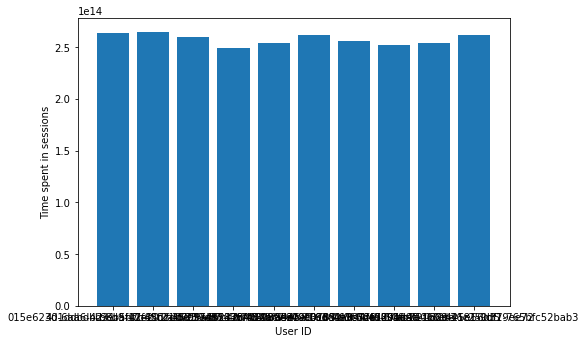

In [127]:
dropdown_timeframe_timespentsess = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_timespentsess = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_timespentsess = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_timespentsess(change):
    common_filtering_timespentsess(change.new, dropdown_user_timespentsess.value)

def dropdown_user_eventhandler_timespentsess(change):
    common_filtering_timespentsess(dropdown_timeframe_timespentsess.value, change.new)
    
def common_filtering_timespentsess(timeframe, user):
    output_widget_timespentsess.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget_timespentsess:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.set_ylabel('Time spent in sessions')
        ax.set_xlabel('User ID')
        ax.bar(df_processed_timeframed['userId'], df_processed_timeframed['duration'])
        display(df_processed_timeframed)

dropdown_timeframe_timespentsess.observe(dropdown_timeframe_eventhandler_timespentsess, names='value')
dropdown_user_timespentsess.observe(dropdown_user_eventhandler_timespentsess, names='value')
display(dropdown_timeframe_timespentsess)
display(dropdown_user_timespentsess)

In [128]:
display(output_widget_timespentsess)

Output()

In [133]:
total_duration = df_processed.loc[df_processed['userId'] == '015e623d-6aa6-4231-af17-85cc106995b6']['duration'].sum()
total_hours = total_duration.days * 24 + total_duration.seconds//3600
total_hours

4131

## Show ratings of users


Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

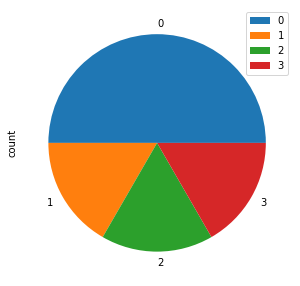

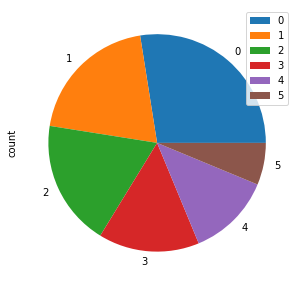

In [135]:
dropdown_timeframe_ratings = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_ratings = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_ratings = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_ratings(change):
    common_filtering_ratings(change.new, dropdown_user_ratings.value)

def dropdown_user_eventhandler_ratings(change):
    common_filtering_ratings(dropdown_timeframe_ratings.value, change.new)
    
def common_filtering_ratings(timeframe, user):
    output_widget_ratings.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget_ratings:
        df_rating = df_user_timeframed.drop(df_user_timeframed[df_user_timeframed['type'] != "CORE_SCENE_RATE"].index)
        df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
        df_rating['ratingValue'] = [d['ratingValue'] for d in df_rating['data_str']]
        df_rating['ratingCategory'] = [d['ratingCategory'] for d in df_rating['data_str']]
        df_rating = df_rating.drop('data', axis=1)
        df_rating = df_rating.drop('data_str', axis=1)
        df_rating_grouped = pd.DataFrame({'temp' : df_rating.groupby(["ratingValue"])['type']}).reset_index()
        df_rating_grouped['count'] = [len(d[1]) for d in df_rating_grouped['temp']]
        df_rating_grouped = df_rating_grouped.drop('temp', axis=1)
        df_rating_grouped.columns = ['ratingValue', 'count']
        plot = df_rating_grouped.plot.pie(y='count', figsize=(5, 5))
        display(plot)

dropdown_timeframe_ratings.observe(dropdown_timeframe_eventhandler_ratings, names='value')
dropdown_user_ratings.observe(dropdown_user_eventhandler_ratings, names='value')
display(dropdown_timeframe_ratings)
display(dropdown_user_ratings)

# Histograms

## Histogram showing concurrent users throughout an average day

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

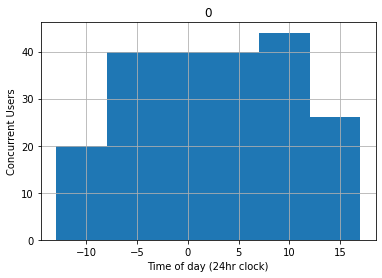

In [136]:
dropdown_timeframe_hist = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_hist = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_hist = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_hist(change):
    common_filtering_hist(change.new, dropdown_user_hist.value)

def dropdown_user_eventhandler_hist(change):
    common_filtering_hist(dropdown_timeframe_hist.value, change.new)
    
def get_times_active(row):
    end = row['time'].hour
    start = row['time'].hour - row['duration'].seconds//3600
    return_set = set()
    for i in range(end - start + 1):
        return_set.add(str(start + i))
    return return_set

def common_filtering_hist(timeframe, user):
    output_widget_hist.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget_hist:
        df_processed_user_timeframed['hours_active'] = df_processed_user_timeframed.apply(get_times_active, axis=1) 
        df_pre_fri_hist = df_processed_user_timeframed.loc[df_processed_user_timeframed['weekday'] == 'Monday']
        
        data_for_hist = {}
            
        count = 0
        for times in df_pre_fri_hist['hours_active']:
            for time in times:
                data_for_hist[count] = float(time)
                count += 1

        df_fri_hist = pd.DataFrame(data_for_hist, index = [0])
        df_fri_hist = df_fri_hist.reindex(sorted(df_fri_hist.columns), axis=1)
        
        axarr = df_fri_hist.transpose().hist(bins=6)

        for ax in axarr.flatten():
            ax.set_xlabel("Time of day (24hr clock)")
            ax.set_ylabel("Concurrent Users")
        
        display(axarr)


dropdown_timeframe_hist.observe(dropdown_timeframe_eventhandler_hist, names='value')
dropdown_user_hist.observe(dropdown_user_eventhandler_hist, names='value')
display(dropdown_timeframe_hist)
display(dropdown_user_hist)

In [137]:
display(output_widget_hist)

Output()

## Histogram showing length of sessions

In [139]:
dropdown_timeframe_histsess = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_histsess = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_histsess = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_histsess(change):
    common_filtering_histsess(change.new, dropdown_user_histsess.value)

def dropdown_user_eventhandler_histsess(change):
    common_filtering_histsess(dropdown_timeframe_histsess.value, change.new)
    
def common_filtering_histsess(timeframe, user):
    output_widget_histsess.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget_histsess:
        df_sesh_len_hist = df_processed_user_timeframed[['duration']].copy()
        df_sesh_len_hist['minutes'] = [d.total_seconds()/60 for d in df_processed_user_timeframed['duration']]
        df_min_hist = df_sesh_len_hist[['minutes']].copy()
        axarr = df_min_hist.hist(bins=6)

        for ax in axarr.flatten():
            ax.set_xlabel("Length of session (minutes)")
            ax.set_ylabel("Number of sessions")
        
        display(axarr)

dropdown_timeframe_histsess.observe(dropdown_timeframe_eventhandler_histsess, names='value')
dropdown_user_histsess.observe(dropdown_user_eventhandler_histsess, names='value')
display(dropdown_timeframe_histsess)
display(dropdown_user_histsess)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

## Radar graph showing average ratings for each category

In [142]:
import ast

df_rating_cat_grouped = None

dropdown_timeframe_radarrating = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       description='Timeframe:')

a = df['userId'].unique()
a = np.append(['All'], a)

dropdown_user_radarrating = widgets.Dropdown(
       options=a,
       value='All',
       description='User ID(s):')
       
output_widget_radarrating = widgets.Output()

today = dt.datetime.now()
timeframe_ago = dt.datetime(1970, 1, 1)


def dropdown_timeframe_eventhandler_radarrating(change):
    common_filtering_radarrating(change.new, dropdown_user_radarrating.value)

def dropdown_user_eventhandler_radarrating(change):
    common_filtering_radarrating(dropdown_timeframe_radarrating.value, change.new)
    
def common_filtering_radarrating(timeframe, user):
    output_widget_radarrating.clear_output()
    
    #timeframe
    if timeframe == 'Day':
        timeframe_ago = dt.datetime(today.year, today.month, day=today.day)
    elif timeframe == 'Week':
        idx = (today.weekday() + 1) % 7 # MON = 0, SUN = 6 -> SUN = 0 .. SAT = 6
        last_sun = today - dt.timedelta(7+idx-6)
        timeframe_ago = dt.datetime(last_sun.year, last_sun.month, day=last_sun.day)
    elif timeframe == 'Month':
        timeframe_ago = dt.datetime(today.year, today.month, day=1)
    elif timeframe == 'Year':
        timeframe_ago = dt.datetime(today.year, 1, day=1)
    else:
        timeframe_ago = dt.datetime(1970, 1, 1)
    df_processed_timeframed = df_processed.drop(df_processed[df_processed.date < timeframe_ago.date()].index)
    df_timeframed = df.drop(df[pd.to_datetime(df.timestamp) < timeframe_ago].index)
    df_timeframed['week_number'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for d in df_timeframed['timestamp']]
    
    #user
    df_processed_user_timeframed = df_processed_timeframed
    df_user_timeframed = df_timeframed
    
    if user != 'All':
        dftemp = df_processed_timeframed
        df_processed_user_timeframed = dftemp.drop(dftemp[dftemp.userId != str(user)].index)
        df_user_timeframed = df_timeframed.drop(df_timeframed[df_timeframed.userId != str(user)].index)
    
    with output_widget_radarrating:
        df_rating = df_user_timeframed.drop(df_user_timeframed[df_user_timeframed['type'] != "CORE_SCENE_RATE"].index)
        df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
        df_rating['ratingValue'] = [d['ratingValue'] for d in df_rating['data_str']]
        df_rating['ratingCategory'] = [d['ratingCategory'] for d in df_rating['data_str']]
        df_rating = df_rating.drop('data', axis=1)
        df_rating = df_rating.drop('data_str', axis=1)
        df_rating_cat_grouped = pd.DataFrame({'mean' : df_rating.groupby(["ratingCategory"])['ratingValue'].mean()}).reset_index()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="polar")

        # theta has 5 different angles, and the first one repeated
        theta = np.arange(len(df_rating_cat_grouped) + 1) / float(len(df_rating_cat_grouped)) * 2 * np.pi
        # values has the 5 values from 'mean', with the first element repeated
        values = df_rating_cat_grouped['mean'].values
        values = np.append(values, values[0])

        # draw the polygon and the mark the points for each angle/value combination
        l1, = ax.plot(theta, values, color="C2", marker="o", label="Mean rating")
        plt.xticks(theta[:-1], df_rating_cat_grouped['ratingCategory'], color='grey', size=12)
        ax.tick_params(pad=10) # to increase the distance of the labels to the plot
        # fill the area of the polygon with green and some transparency
        ax.fill(theta, values, 'green', alpha=0.1)

        # plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
        plt.title("Average Ratings for Different Categories")
        
        display(plt.show())
        display(df_rating_cat_grouped)

dropdown_timeframe_radarrating.observe(dropdown_timeframe_eventhandler_radarrating, names='value')
dropdown_user_radarrating.observe(dropdown_user_eventhandler_radarrating, names='value')
display(dropdown_timeframe_radarrating)
display(dropdown_user_radarrating)

Dropdown(description='Timeframe:', options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Day')

Dropdown(description='User ID(s):', options=('All', '015e623d-6aa6-4231-af17-85cc106995b6', '401ddbdb-b8d9-42e…

In [143]:
display(output_widget_radarrating)

Output()

In [144]:
df_rating_cat_grouped